### Homework 3

#### Instructions:

Same as homework 2: apply the logistic regression Machine Learning workflow to adult_small.csv.

But now use the column transformer, pipelines and gridsearch to optimize hyperparameters. 

In [3]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Load dataset
adult = pd.read_csv('adult_small.csv')

# Remove duplicates
adult.drop_duplicates(inplace=True)
adult.sample(5)

,age,education.num,race,sex,hours.per.week,income
2895,35,9,Black,Male,40,<=50K
2356,37,10,White,Male,45,<=50K
1617,58,9,White,Male,52,>50K
318,33,7,White,Female,40,<=50K
3765,44,11,White,Female,40,<=50K


In [4]:
# Features and target
X = adult.drop(columns=['income'])
y = adult['income']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
print(f"Shapes: X_train: {X_train.shape}, y_train: {y_train.shape},\
 X_test: {X_test.shape}, y_test: {y_test.shape}\n")

# Preprocessing for numeric and categorical features

# Create two transformers and one estimator
ohe = OneHotEncoder()
scaler = StandardScaler()
logreg = LogisticRegression(random_state=42)

# no need here to make sub-pipelines, only one transformer needed per feature type
preprocessor = make_column_transformer(
    (scaler, ['age', 'education.num', 'hours.per.week']),
    (ohe, ['race', 'sex'])
)

# Create a pipeline with preprocessor and logistic regression
pipe = make_pipeline(preprocessor, logreg)
pipe

Shapes: X_train: (2641, 5), y_train: (2641,), X_test: (661, 5), y_test: (661,)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'education.num',
                                                   'hours.per.week']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['race', 'sex'])])),
                ('logisticregression', LogisticRegression(random_state=42))])

In [5]:
#list(pipe.get_params().keys())

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters: {'logisticregression__C': 1, 'logisticregression__solver': 'lbfgs'}
Best Cross-Validation Score: 0.6613491652289374
              precision    recall  f1-score   support

       <=50K       0.81      0.94      0.87       481
        >50K       0.71      0.42      0.53       180

    accuracy                           0.80       661
   macro avg       0.76      0.68      0.70       661
weighted avg       0.78      0.80      0.78       661



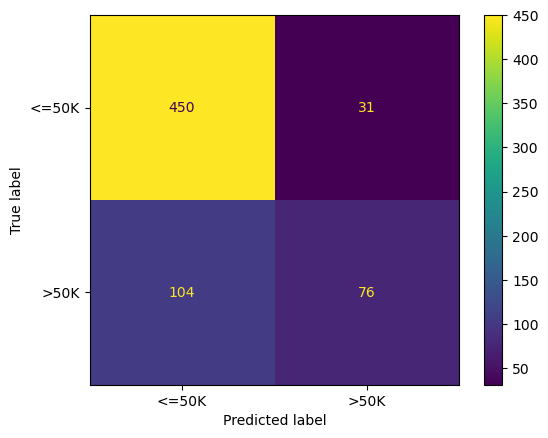

In [6]:
# Define parameter grid for GridSearchCV

# Nothing useful to optimize in the preprocessor (scaling, ohe) I think
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__solver': ['liblinear', 'lbfgs']
}

# Instantiate GridSearchCV
gs = GridSearchCV(pipe, param_grid, cv=10, scoring='f1_macro', n_jobs=-1, refit=True, verbose=1)

# Fit the model
gs.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters:", gs.best_params_)
print("Best Cross-Validation Score:", gs.best_score_)

# Test set performance
y_test_predicted = gs.predict(X_test)
print(classification_report(y_test, y_test_predicted))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_predicted)
